In [1]:
import pandas as pd
import numpy as np
import os
import os
import torch
import pandas as pd
import numpy as np
from tqdm import tqdm
from PIL import Image, ImageFile
from torch.utils.data import DataLoader, TensorDataset
from torchvision.transforms import Resize, ToTensor, Normalize, Compose
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
import cv2
import matplotlib.pyplot as plt
import torch
import seaborn as sns
from pathlib import Path
from sklearn.cluster import KMeans
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Lasso
import pickle
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
import umap
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from imblearn.under_sampling import RandomUnderSampler
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.combine import SMOTEENN

os.environ["TF_GPU_ALLOCATOR"] = "cuda_malloc_async"

2024-11-26 18:09:33.801029: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 18:09:33.810582: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 18:09:33.822091: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 18:09:33.826994: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-26 18:09:33.835738: I tensorflow/core/platform/cpu_feature_guar

In [2]:
path = "/media/guimcc/Elements/data_2"

# Load sales data
train_df = pd.read_csv(Path(path + '/train.csv'), parse_dates=['release_date'])
test_df = pd.read_csv(Path(path + '/test.csv'), parse_dates=['release_date'])

In [3]:
train_csv = pd.read_csv(Path(path + '/train.csv'), parse_dates=['release_date'])
test_csv = pd.read_csv(Path(path + '/test.csv'), parse_dates=['release_date'])

In [4]:
ImageFile.LOAD_TRUNCATED_IMAGES = True


class ZeroShotDataset():
    def __init__(self, data_df, img_root, gtrends, cat_dict, col_dict, fab_dict, trend_len):
        self.data_df = data_df
        self.gtrends = gtrends
        self.cat_dict = cat_dict
        self.col_dict = col_dict
        self.fab_dict = fab_dict
        self.trend_len = trend_len
        self.img_root = img_root

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        return self.data_df.iloc[idx, :]

    def preprocess_data(self):
        data = self.data_df

        # Get the Gtrends time series associated with each product
        # Read the images (extracted image features) as well
        gtrends, image_features = [], []
        img_transforms = Compose([Resize((256, 256)), ToTensor(), Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
        for (idx, row) in tqdm(data.iterrows(), total=len(data), ascii=True):
            cat, col, fab, fiq_attr, start_date, img_path = row['category'], row['color'], row['fabric'], row['extra'], \
                row['release_date'], row['image_path']

            # Get the gtrend signal up to the previous year (52 weeks) of the release date
            gtrend_start = start_date - pd.DateOffset(weeks=52) # Set the initial date to 52 weeks before the release date
            cat_gtrend = self.gtrends.loc[gtrend_start:start_date][cat][-52:].values[:self.trend_len] # Get the last 52 weeks of the gtrend signal and "store - it" to each item
            col_gtrend = self.gtrends.loc[gtrend_start:start_date][col][-52:].values[:self.trend_len]
            fab_gtrend = self.gtrends.loc[gtrend_start:start_date][fab][-52:].values[:self.trend_len]

            cat_gtrend = MinMaxScaler().fit_transform(cat_gtrend.reshape(-1,1)).flatten() # Normalize the gtrend signals - all categories on the same scale
            col_gtrend = MinMaxScaler().fit_transform(col_gtrend.reshape(-1,1)).flatten()
            fab_gtrend = MinMaxScaler().fit_transform(fab_gtrend.reshape(-1,1)).flatten()
            multitrends =  np.vstack([cat_gtrend, col_gtrend, fab_gtrend])


            # Read images
            img = Image.open(os.path.join(self.img_root, img_path)).convert('RGB')

            # Append them to the lists
            gtrends.append(multitrends)
            image_features.append(img_transforms(img))

        # Convert to numpy arrays
        gtrends = np.array(gtrends)

        # Remove non-numerical information
        data.drop(['external_code', 'season', 'release_date', 'image_path'], axis=1, inplace=True)

        # Create tensors for each part of the input/output
        item_sales, temporal_features = torch.FloatTensor(data.iloc[:, :12].values), torch.FloatTensor(
            data.iloc[:, 13:17].values)
        categories, colors, fabrics = [self.cat_dict[val] for val in data.iloc[:].category.values], \
                                       [self.col_dict[val] for val in data.iloc[:].color.values], \
                                       [self.fab_dict[val] for val in data.iloc[:].fabric.values]

        
        categories, colors, fabrics = torch.LongTensor(categories), torch.LongTensor(colors), torch.LongTensor(fabrics)
        gtrends = torch.FloatTensor(gtrends)
        images = torch.stack(image_features)

        return TensorDataset(item_sales, categories, colors, fabrics, temporal_features, gtrends, images)

    def get_loader(self, batch_size, train=True):
        print('Starting dataset creation process...')
        data_with_gtrends = self.preprocess_data()
        data_loader = None
        if train:
            data_loader = DataLoader(data_with_gtrends, batch_size=batch_size, shuffle=True, num_workers=4)
        else:
            data_loader = DataLoader(data_with_gtrends, batch_size=1, shuffle=False, num_workers=4)
        print('Done.')

        return data_loader

In [5]:
from pathlib import Path

 # Load category and color encodings
cat_dict = torch.load(Path(path + '/category_labels.pt'))
col_dict = torch.load(Path(path + '/color_labels.pt'))
fab_dict = torch.load(Path(path + '/fabric_labels.pt'))

gtrends = pd.read_csv(Path(path + '/gtrends.csv'), index_col=[0], parse_dates=True)

/tmp/ipykernel_43967/1618174958.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cat_dict = torch.load(Path(path + '/category_labels.pt'))
/tmp/ipykernel_43967/1618174958

In [6]:
train_loader = ZeroShotDataset(train_df, Path(path + '/images'), gtrends, cat_dict, col_dict,
                                   fab_dict, 52).get_loader(batch_size=32, train=True)
test_loader = ZeroShotDataset(test_df, Path(path + '/images'), gtrends, cat_dict, col_dict,
                                  fab_dict, 52).get_loader(batch_size=1, train=False)

Starting dataset creation process...


100%|##########| 5080/5080 [03:04<00:00, 27.55it/s]


Done.
Starting dataset creation process...


100%|##########| 497/497 [00:21<00:00, 22.84it/s]


Done.


In [7]:
# Extract the data from the DataLoader for EDA
item_sales_list, categories_list, colors_list, fabrics_list, temporal_features_list, gtrends_list, images_list = [], [], [], [], [], [], []

for item_sales_i, categories_i, colors_i, fabrics_i, temporal_features_i, gtrends_i, images_i in train_loader:
    item_sales_list.append(item_sales_i.numpy())
    categories_list.append(categories_i.numpy())
    colors_list.append(colors_i.numpy())
    fabrics_list.append(fabrics_i.numpy())
    temporal_features_list.append(temporal_features_i.numpy())
    gtrends_list.append(gtrends_i.numpy())
    images_list.append(images_i.numpy())

# Convert lists to arrays for analysis
item_sales = np.concatenate(item_sales_list)
categories = np.concatenate(categories_list)
colors = np.concatenate(colors_list)
fabrics = np.concatenate(fabrics_list)
temporal_features = np.concatenate(temporal_features_list)
gtrends = np.concatenate(gtrends_list)
images = np.concatenate(images_list)

In [8]:
# Extract the data from the DataLoader for EDA
item_sales_list_test, categories_list_test, colors_list_test, fabrics_list_test, temporal_features_list_test, gtrends_list_test, images_list_test = [], [], [], [], [], [], []

for item_sales_i, categories_i, colors_i, fabrics_i, temporal_features_i, gtrends_i, images_i in test_loader:
    item_sales_list_test.append(item_sales_i.numpy())
    categories_list_test.append(categories_i.numpy())
    colors_list_test.append(colors_i.numpy())
    fabrics_list_test.append(fabrics_i.numpy())
    temporal_features_list_test.append(temporal_features_i.numpy())
    gtrends_list_test.append(gtrends_i.numpy())
    images_list_test.append(images_i.numpy())

item_sales_test = np.concatenate(item_sales_list_test)
categories_test = np.concatenate(categories_list_test)
colors_test = np.concatenate(colors_list_test)
fabrics_test = np.concatenate(fabrics_list_test)
temporal_features_test = np.concatenate(temporal_features_list_test)
gtrends_test = np.concatenate(gtrends_list_test)
images_test = np.concatenate(images_list_test)

Load CLIP Embeddings

In [9]:
embeddings_dict = torch.load('image_embeddings.pt')
embeddings_dict_test = torch.load('image_embeddings_test.pt')

/tmp/ipykernel_43967/3281127973.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  embeddings_dict = torch.load('image_embeddings.pt')
/tmp/ipykernel_43967/3281127973.py:2:

In [10]:
embeddings = [embeddings_dict[filename] for filename in train_csv['image_path']]
embeddings_test = [embeddings_dict_test[filename] for filename in test_csv['image_path']]

In [11]:
embeddings_array = np.array(embeddings)
embeddings_array_test = np.array(embeddings_test)

Temporal features

In [12]:
# Convert scaled temporal features back to integers
week_of_year = (temporal_features[:, 1] * 52).astype(int)  # Week of the year (1 to 52)
month_of_year = (temporal_features[:, 2] * 12).astype(int)  # Month of the year (1 to 12)
year = (temporal_features[:, 3] * 10).astype(int)  # Year (scaled up to a meaningful range)

# Additional derived features
is_weekend = (week_of_year % 7 >= 5).astype(int)  # Flag indicating if it's a weekend (Saturday or Sunday)
quarter = ((month_of_year - 1) // 3 + 1).astype(int)  # Calculate the quarter (1 to 4)
season = np.select(
    [month_of_year <= 2, (month_of_year >= 3) & (month_of_year <= 5),
     (month_of_year >= 6) & (month_of_year <= 8), month_of_year >= 9],
    [0, 1, 2, 3])  # Define seasons (Winter, Spring, Summer, Fall)

# Combine all features into a new feature matrix
temporal_features_engineered = np.column_stack([
    week_of_year, month_of_year, year, is_weekend, quarter, season
])

In [13]:
# Convert scaled temporal features back to integers for test data
test_week_of_year = (temporal_features_test[:, 1] * 52).astype(int)  # Week of the year (1 to 52)
test_month_of_year = (temporal_features_test[:, 2] * 12).astype(int)  # Month of the year (1 to 12)
test_year = (temporal_features_test[:, 3] * 10).astype(int)  # Year (scaled up to a meaningful range)

# Additional derived features for test data
test_is_weekend = (test_week_of_year % 7 >= 5).astype(int)  # Flag indicating if it's a weekend (Saturday or Sunday)
test_quarter = ((test_month_of_year - 1) // 3 + 1).astype(int)  # Calculate the quarter (1 to 4)
test_season = np.select(
    [test_month_of_year <= 2, (test_month_of_year >= 3) & (test_month_of_year <= 5),
     (test_month_of_year >= 6) & (test_month_of_year <= 8), test_month_of_year >= 9],
    [0, 1, 2, 3])  # Define seasons (Winter, Spring, Summer, Fall)

# Combine all features into a new feature matrix for test data
test_temporal_features_engineered = np.column_stack([
    test_week_of_year, test_month_of_year, test_year, test_is_weekend, test_quarter, test_season
])

Rolling features

In [14]:
# Get the dimensions of gtrends
num_samples, num_trends, trend_len = gtrends.shape

# Initialize lists for the reduced rolling features
rolling_avg_4w_list = []
rolling_avg_12w_list = []
rolling_sum_4w_list = []
rolling_sum_12w_list = []

# Calculate rolling features for each trend channel
for i in range(num_samples):
    rolling_avg_4w_sample = []
    rolling_avg_12w_sample = []
    rolling_sum_4w_sample = []
    rolling_sum_12w_sample = []
    
    for j in range(num_trends):
        # Use pandas Series to calculate rolling averages and sums for each trend
        gtrend_series = pd.Series(gtrends[i, j])

        # Calculate rolling averages and sums and take the last value of each rolling window
        rolling_avg_4w_sample.append(gtrend_series.rolling(window=4, min_periods=1).mean().iloc[-1])
        rolling_avg_12w_sample.append(gtrend_series.rolling(window=12, min_periods=1).mean().iloc[-1])
        rolling_sum_4w_sample.append(gtrend_series.rolling(window=4, min_periods=1).sum().iloc[-1])
        rolling_sum_12w_sample.append(gtrend_series.rolling(window=12, min_periods=1).sum().iloc[-1])
    
    # Append the results for this sample
    rolling_avg_4w_list.append(rolling_avg_4w_sample)
    rolling_avg_12w_list.append(rolling_avg_12w_sample)
    rolling_sum_4w_list.append(rolling_sum_4w_sample)
    rolling_sum_12w_list.append(rolling_sum_12w_sample)

# Convert lists to arrays
rolling_avg_4w = np.array(rolling_avg_4w_list)
rolling_avg_12w = np.array(rolling_avg_12w_list)
rolling_sum_4w = np.array(rolling_sum_4w_list)
rolling_sum_12w = np.array(rolling_sum_12w_list)

# Combine only the reduced rolling features into a single array
gtrends_with_rolling_reduced = np.hstack([
    rolling_avg_4w, rolling_avg_12w, rolling_sum_4w, rolling_sum_12w
])

In [15]:
# Get the dimensions of gtrends_test
num_samples_test, num_trends_test, trend_len_test = gtrends_test.shape

# Initialize lists for the reduced rolling features
rolling_avg_4w_test_list = []
rolling_avg_12w_test_list = []
rolling_sum_4w_test_list = []
rolling_sum_12w_test_list = []

# Calculate rolling features for each trend channel
for i in range(num_samples_test):
    rolling_avg_4w_sample_test = []
    rolling_avg_12w_sample_test = []
    rolling_sum_4w_sample_test = []
    rolling_sum_12w_sample_test = []
    
    for j in range(num_trends_test):
        # Use pandas Series to calculate rolling averages and sums for each trend
        gtrend_test_series = pd.Series(gtrends_test[i, j])

        # Calculate rolling averages and sums and take the last value of each rolling window
        rolling_avg_4w_sample_test.append(gtrend_test_series.rolling(window=4, min_periods=1).mean().iloc[-1])
        rolling_avg_12w_sample_test.append(gtrend_test_series.rolling(window=12, min_periods=1).mean().iloc[-1])
        rolling_sum_4w_sample_test.append(gtrend_test_series.rolling(window=4, min_periods=1).sum().iloc[-1])
        rolling_sum_12w_sample_test.append(gtrend_test_series.rolling(window=12, min_periods=1).sum().iloc[-1])
    
    # Append the results for this sample
    rolling_avg_4w_test_list.append(rolling_avg_4w_sample_test)
    rolling_avg_12w_test_list.append(rolling_avg_12w_sample_test)
    rolling_sum_4w_test_list.append(rolling_sum_4w_sample_test)
    rolling_sum_12w_test_list.append(rolling_sum_12w_sample_test)

# Convert lists to arrays
rolling_avg_4w_test = np.array(rolling_avg_4w_test_list)
rolling_avg_12w_test = np.array(rolling_avg_12w_test_list)
rolling_sum_4w_test = np.array(rolling_sum_4w_test_list)
rolling_sum_12w_test = np.array(rolling_sum_12w_test_list)

# Combine only the reduced rolling features into a single array
gtrends_test_with_rolling_reduced = np.hstack([
    rolling_avg_4w_test, rolling_avg_12w_test,
    rolling_sum_4w_test, rolling_sum_12w_test
])

Bag of Visual Words

In [16]:
def denormalize_image(image):
    image = np.transpose(image, (1, 2, 0))   
    
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    
    image = std * image + mean
    image = np.clip(image, 0, 1)
    image = (image * 255).astype(np.uint8)
    
    return image

step_size = 5
kp = [cv2.KeyPoint(x, y, step_size) for y in range(0, 256, step_size) 
                                    for x in range(0, 256, step_size)]

sift = cv2.SIFT_create()
def extact_sift_features_dense(image_array):
    
    image = denormalize_image(image_array)

    _, descriptors = sift.compute(image, kp)
    return descriptors

In [17]:
visual_words = np.load('visual_words_2.npy')
# Load descriptors_list_dense from the file
with open('descriptors_list_dense_2.pkl', 'rb') as file:
    descriptors_list_dense = pickle.load(file)
    # Load the KMeans model
with open('kmeans_model_2.pkl', 'rb') as file:
    kmeans = pickle.load(file)

In [18]:
# Function to create a histogram of visual words for an image
def create_histogram(descriptors, visual_words):
    histogram = np.zeros(len(visual_words))
    if descriptors is not None:
        words = kmeans.predict(descriptors)
        for word in words:
            histogram[word] += 1
    return histogram

# Create histograms for all images
histograms = []
for idx in tqdm(range(len(images))):
    descriptors = descriptors_list_dense[idx]
    histogram = create_histogram(descriptors, visual_words)
    histograms.append(histogram)

# Convert histograms to a NumPy array
X_train_bovw = np.array(histograms)

histograms_test = []
for idx in tqdm(range(len(images_test))):
    descriptors = extact_sift_features_dense(images_test[idx])
    histogram = create_histogram(descriptors, visual_words)
    histograms_test.append(histogram)

X_test_bovw = np.array(histograms_test)

 33%|███▎      | 1674/5080 [00:02<00:05, 618.78it/s]


IndexError: list index out of range

Combine Train and Test

In [19]:
item_sales_combined = np.concatenate([item_sales, item_sales_test])
categories_combined = np.concatenate([categories, categories_test])
colors_combined = np.concatenate([colors, colors_test])
fabrics_combined = np.concatenate([fabrics, fabrics_test])
# temporal_features_combined = np.concatenate([temporal_features, temporal_features_test])
temporal_features_engineered_combined = np.concatenate([temporal_features_engineered, test_temporal_features_engineered])
# gtrends_combined = np.concatenate([gtrends, gtrends_test])
gtrends_with_rolling_reduced_combined = np.concatenate([gtrends_with_rolling_reduced, gtrends_test_with_rolling_reduced])
images_combined = np.concatenate([images, images_test])
embeddings_combined = np.concatenate([embeddings_array, embeddings_array_test])
visual_words_combined = np.concatenate([X_train_bovw, X_test_bovw])

In [20]:
print(f"Shape of item_sales_combined: {item_sales_combined.shape}")
print(f"Shape of categories_combined: {categories_combined.shape}")
print(f"Shape of colors_combined: {colors_combined.shape}")
print(f"Shape of fabrics_combined: {fabrics_combined.shape}")
print(f"Shape of temporal_features_engineered_combined: {temporal_features_engineered_combined.shape}")
print(f"Shape of gtrends_with_rolling_reduced_combined: {gtrends_with_rolling_reduced_combined.shape}")
print(f"Shape of images_combined: {images_combined.shape}")
print(f"Shape of embeddings_combined: {embeddings_combined.shape}")
print(f"Shape of visual_words_combined: {visual_words_combined.shape}")

Shape of item_sales_combined: (5577, 12)
Shape of categories_combined: (5577,)
Shape of colors_combined: (5577,)
Shape of fabrics_combined: (5577,)
Shape of temporal_features_engineered_combined: (5577, 6)
Shape of gtrends_with_rolling_reduced_combined: (5577, 12)
Shape of images_combined: (5577, 3, 256, 256)
Shape of embeddings_combined: (5577, 512)
Shape of visual_words_combined: (5577, 200)


In [21]:
X_combined = np.column_stack([
    categories_combined, colors_combined, fabrics_combined,
    temporal_features_engineered_combined, gtrends_with_rolling_reduced_combined, embeddings_combined, visual_words_combined
])

column_names = ['categories', 'colors', 'fabrics'] + ['week_of_year', 'month_of_year', 'year', 'is_weekend', 'quarter', 'season'] + \
                ['rolling_avg_4w', 'rolling_avg_12w', 'rolling_sum_4w', 'rolling_sum_12w'] * 3 + ['image_embedding'] * 512 + ['visual_words'] * 200

print(len(column_names), X_combined.shape)

(
    X_train, X_test,
    item_sales_train, item_sales_test,
    categories_train, categories_test,
    colors_train, colors_test,
    fabrics_train, fabrics_test,
    temporal_features_train, temporal_features_test,
    gtrends_train, gtrends_test,
    images_train, images_test,
    embeddings_train, embeddings_test,
    visual_words_train, visual_words_test
) = train_test_split(
    X_combined,
    item_sales_combined,
    categories_combined,
    colors_combined,
    fabrics_combined,
    temporal_features_engineered_combined,
    gtrends_with_rolling_reduced_combined,
    images_combined,
    embeddings_combined,
    visual_words_combined,
    test_size=0.2,
    random_state=33,
    # Uncomment and modify the following line if you want to stratify the split
    # stratify=(y_combined >= np.median(y_combined)).astype(int)
)

733 (5577, 733)


In [22]:
# Verify the shapes of the splits
print("Training set shapes:")
print(f"X_train: {X_train.shape}")
print(f"item_sales_train: {item_sales_train.shape}")
print(f"categories_train: {categories_train.shape}")
print(f"colors_train: {colors_train.shape}")
print(f"fabrics_train: {fabrics_train.shape}")
print(f"temporal_features_train: {temporal_features_train.shape}")
print(f"gtrends_train: {gtrends_train.shape}")
print(f"images_train: {images_train.shape}")
print(f"embeddings_train: {embeddings_train.shape}")
print(f"visual_words_train: {visual_words_train.shape}")

print("\nTesting set shapes:")
print(f"X_test: {X_test.shape}")
print(f"item_sales_test: {item_sales_test.shape}")
print(f"categories_test: {categories_test.shape}")
print(f"colors_test: {colors_test.shape}")
print(f"fabrics_test: {fabrics_test.shape}")
print(f"temporal_features_test: {temporal_features_test.shape}")
print(f"gtrends_test: {gtrends_test.shape}")
print(f"images_test: {images_test.shape}")
print(f"embeddings_test: {embeddings_test.shape}")
print(f"visual_words_test: {visual_words_test.shape}")

Training set shapes:
X_train: (4461, 733)
item_sales_train: (4461, 12)
categories_train: (4461,)
colors_train: (4461,)
fabrics_train: (4461,)
temporal_features_train: (4461, 6)
gtrends_train: (4461, 12)
images_train: (4461, 3, 256, 256)
embeddings_train: (4461, 512)
visual_words_train: (4461, 200)

Testing set shapes:
X_test: (1116, 733)
item_sales_test: (1116, 12)
categories_test: (1116,)
colors_test: (1116,)
fabrics_test: (1116,)
temporal_features_test: (1116, 6)
gtrends_test: (1116, 12)
images_test: (1116, 3, 256, 256)
embeddings_test: (1116, 512)
visual_words_test: (1116, 200)


### Data exploration

In [23]:
# Calculate total sales per item across the 12 numerical values
total_sales = item_sales.sum(axis=1)
first_sales = item_sales[:, 0]
total_sales_test = item_sales_test.sum(axis=1)
first_sales_test = item_sales_test[:, 0]

treshold = np.percentile(item_sales_combined[:, 0:4].sum(axis=1), 80)
exit_sales = (item_sales_combined[:, 0:4].sum(axis=1) >= treshold).astype(int)
exit_sales_test = (item_sales_test[:, 0:4].sum(axis=1) >= treshold).astype(int)
# exit_sales = (first_sales >= 0.03).astype(int)
# exit_sales_test = (first_sales_test >= 0.03).astype(int)
treshold

0.27868544459342975

In [24]:
item_sales_train[:, 0:4].sum(axis=1)

array([0.34084505, 0.2741784 , 0.99248827, ..., 0.17746478, 0.15211266,
       0.49014086], dtype=float32)

Binary classification

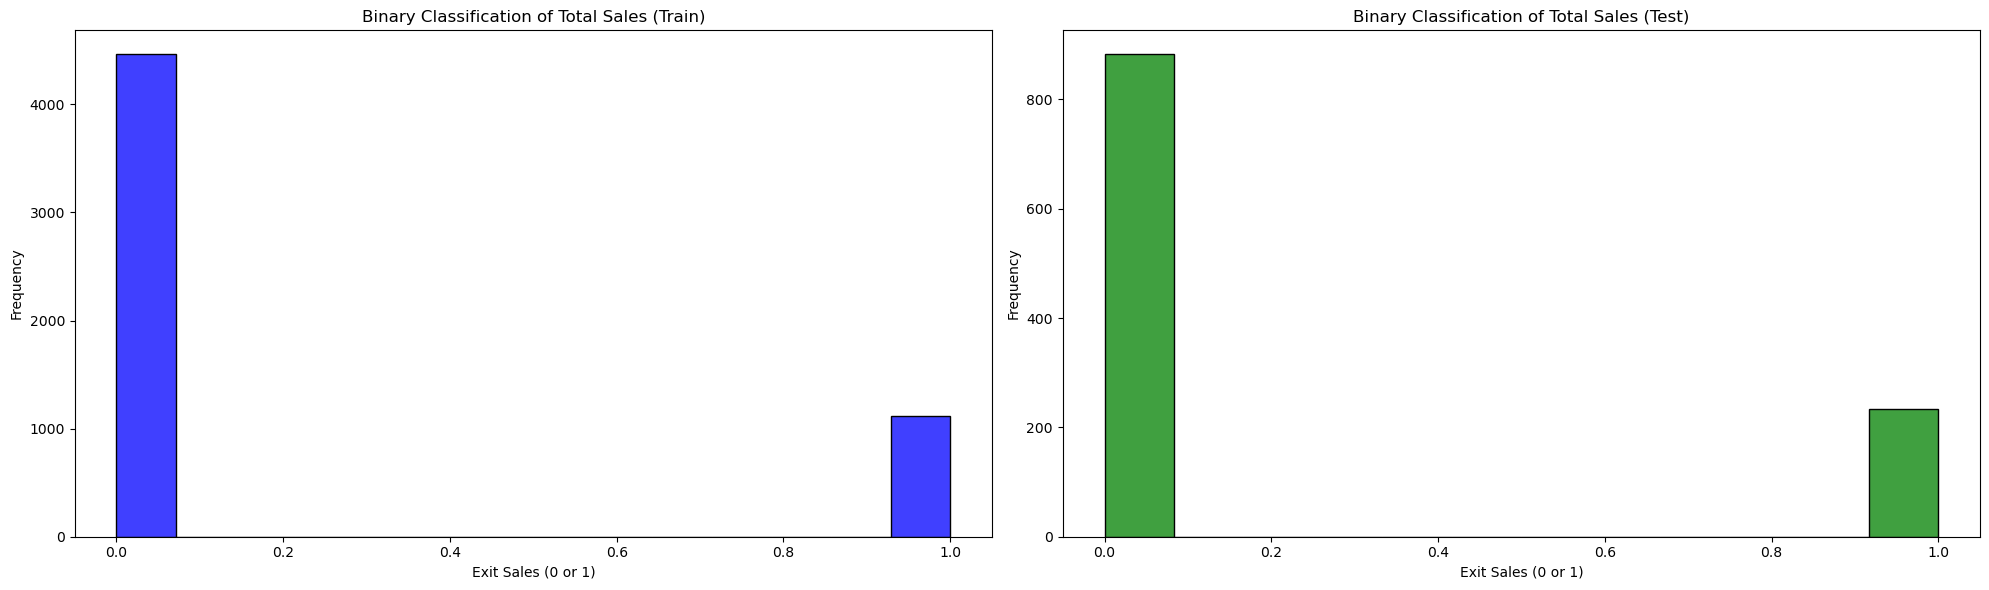

In [25]:
fig, axes = plt.subplots(1, 2, figsize=(20, 6))

# Plot binary classification for training data
sns.histplot(exit_sales, kde=False, color='blue', ax=axes[0])
axes[0].set_title("Binary Classification of Total Sales (Train)")
axes[0].set_xlabel("Exit Sales (0 or 1)")
axes[0].set_ylabel("Frequency")

# Plot binary classification for test data
sns.histplot(exit_sales_test, kde=False, color='green', ax=axes[1])
axes[1].set_title("Binary Classification of Total Sales (Test)")
axes[1].set_xlabel("Exit Sales (0 or 1)")
axes[1].set_ylabel("Frequency")

plt.tight_layout()
plt.show()

Category histogram

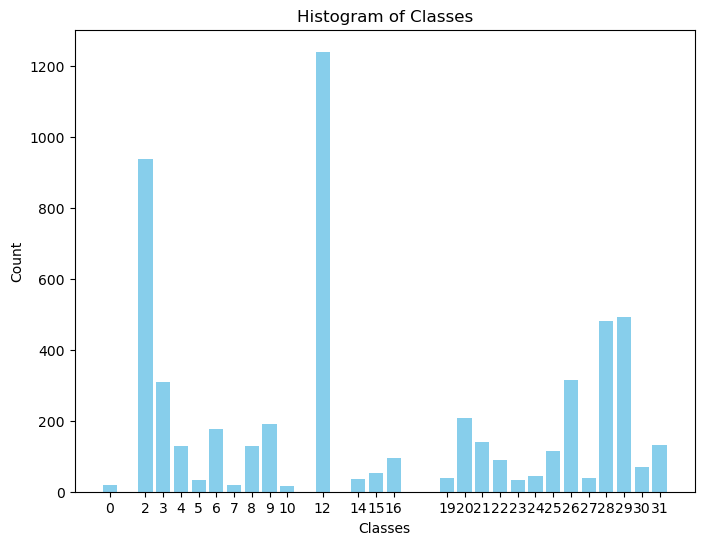

In [26]:
unique_classes, counts = np.unique(categories_combined, return_counts=True)

# Create the histogram
plt.figure(figsize=(8, 6))
plt.bar(unique_classes, counts, color='skyblue')
plt.xlabel('Classes')
plt.ylabel('Count')
plt.title('Histogram of Classes')
plt.xticks(unique_classes)  # Ensure all classes are shown on the x-axis
plt.show()

Sales trend

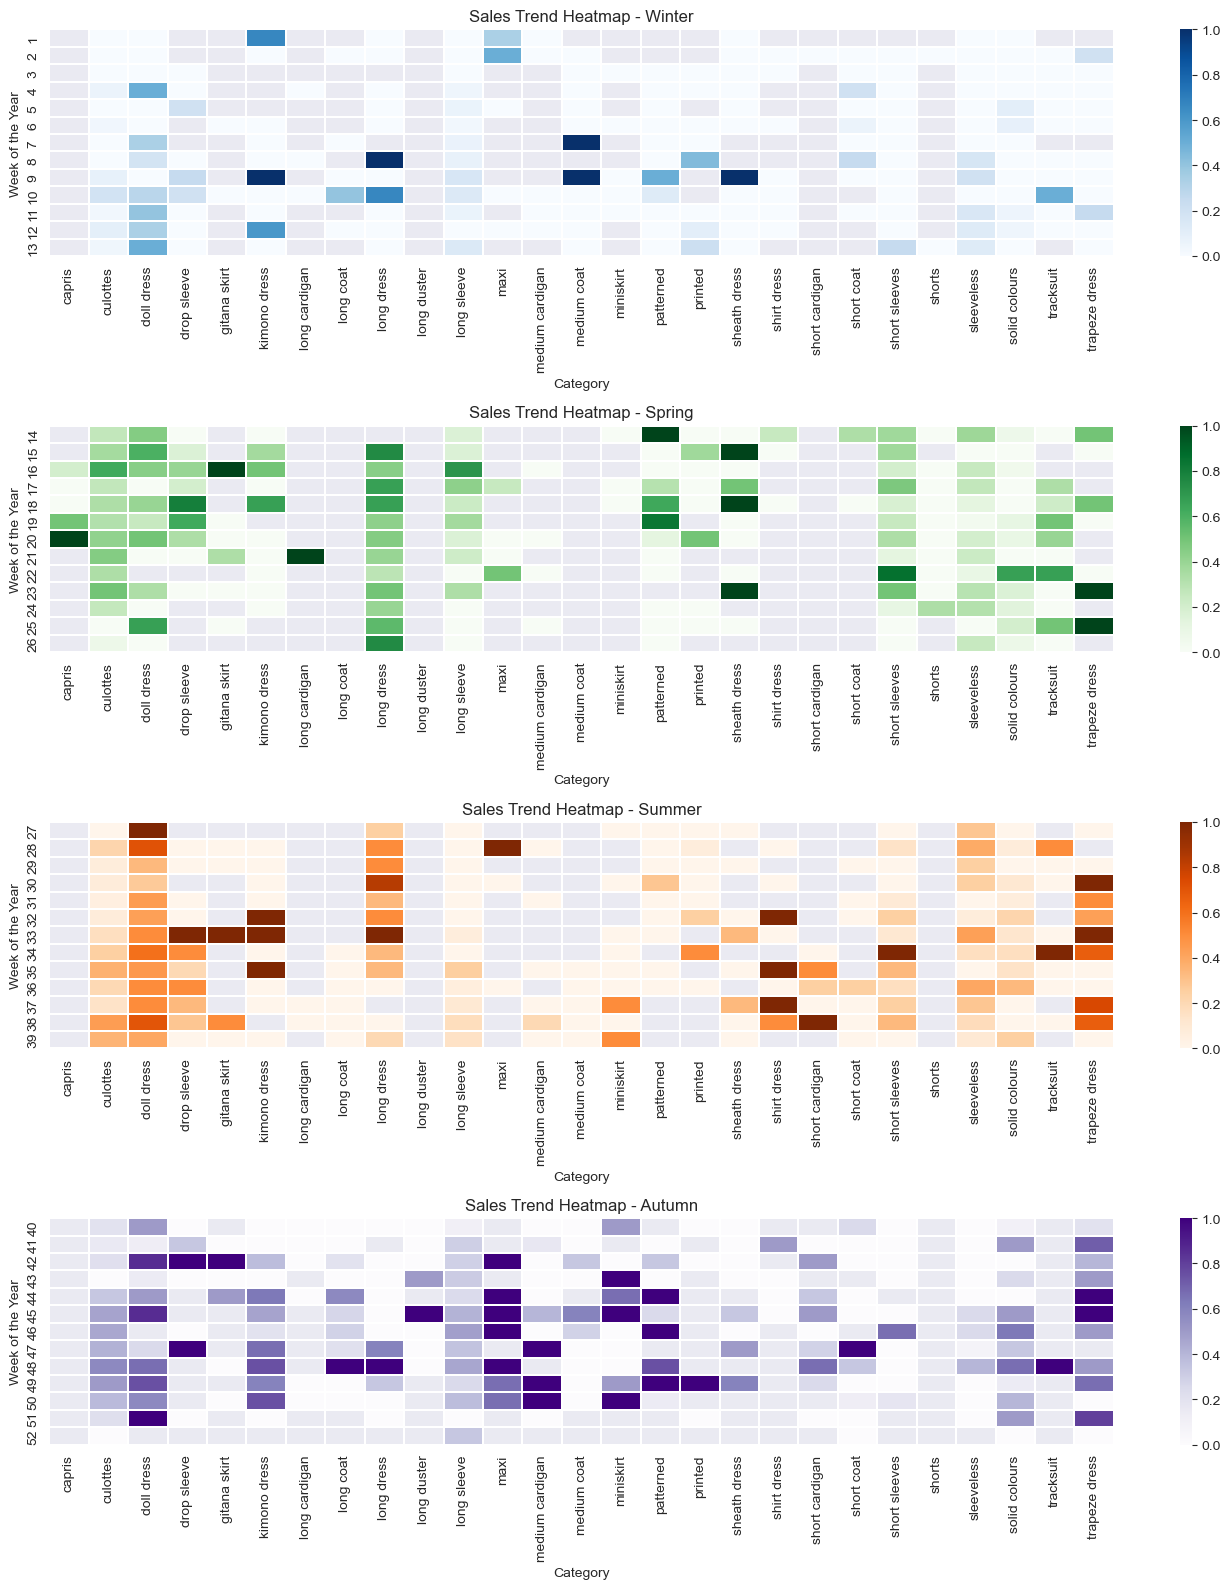

In [27]:
# Convert Week, Month, and Year to proper integers
sales_trend_df = pd.DataFrame({
    "Week": (temporal_features_engineered_combined[:, 0]),  # Week of the year
    "Month": (temporal_features_engineered_combined[:, 1]),  # Month of the year
    "Year": (temporal_features_engineered_combined[:, 2]),  # Year
    # "Total Sales": total_sales,
    "Total Sales": exit_sales,
    "Category": categories_combined
})

sns.set_style("dark")  # Options: "whitegrid", "darkgrid", "dark", "white", "ticks"

# Define a function to classify weeks into seasons
def classify_season(week):
    if week in range(1, 14):  # Weeks 1-13: Winter
        return "Winter"
    elif week in range(14, 27):  # Weeks 14-26: Spring
        return "Spring"
    elif week in range(27, 40):  # Weeks 27-39: Summer
        return "Summer"
    else:  # Weeks 40-52: Autumn
        return "Autumn"

reversed_cat_dict = {v: k for k, v in cat_dict.items()}

# Apply the classification to create a new Season column
sales_trend_df["Category"] = sales_trend_df["Category"].map(reversed_cat_dict)
all_categories = sorted(sales_trend_df["Category"].unique())

sales_trend_df["Season"] = sales_trend_df["Week"].apply(classify_season)

# Calculate the global min and max for the color scale
global_min = sales_trend_df["Total Sales"].min()
global_max = sales_trend_df["Total Sales"].max()

# Plot the heatmap for each season with different colormaps
plt.figure(figsize=(14, 16))
for i, season in enumerate(["Winter", "Spring", "Summer", "Autumn"]):
    season_data = sales_trend_df[sales_trend_df["Season"] == season]
    season_pivot = season_data.pivot_table(values="Total Sales", index="Week", columns="Category", aggfunc='mean').reindex(columns=all_categories)

    # Plot the heatmap for the current season with a consistent color scale
    plt.subplot(4, 1, i + 1)
    sns.heatmap(season_pivot, cmap="Blues" if season == "Winter" else 
                                      "Greens" if season == "Spring" else 
                                      "Oranges" if season == "Summer" else 
                                      "Purples",
                vmin=global_min, vmax=global_max,
                linewidths=0.1)
    
    plt.title(f"Sales Trend Heatmap - {season}")
    plt.xlabel("Category")
    plt.ylabel("Week of the Year")

plt.tight_layout()
plt.show()

### Bag of Words

In [ ]:
sift = cv2.SIFT_create()

descriptors_list_dense = []
for image in tqdm(images):
    descriptors = extact_sift_features_dense(image)
    
    if descriptors is not None:
        descriptors_list_dense.append(descriptors)
    else:
        descriptors_list_dense.append(np.zeros((1, 128)))

In [127]:
# Stack all descriptors together
all_descriptors = np.vstack(descriptors_list_dense)
print(all_descriptors.shape)
# Use K-means to create a visual vocabulary
k = 200  # Number of visual words
kmeans = KMeans(n_clusters=k)
kmeans.fit(all_descriptors)

# Save the cluster centers as the visual vocabulary
visual_words = kmeans.cluster_centers_

(13736320, 128)


In [29]:
# Save descriptors_list_dense to a file
with open('descriptors_list_dense_2.pkl', 'wb') as file:
    pickle.dump(descriptors_list_dense, file)
np.save('visual_words_2.npy', visual_words)
# Save the KMeans model
with open('kmeans_model_2.pkl', 'wb') as file:
    pickle.dump(kmeans, file)

##### Season filtering

In [32]:
def get_season_data(season_code, 
                   temporal_features_train, temporal_features_test,
                   categories_train, categories_test,
                   colors_train, colors_test,
                   fabrics_train, fabrics_test,
                   temporal_features_train_full, temporal_features_test_full,
                   gtrends_train, gtrends_test,
                   images_train, images_test,
                   embeddings_train, embeddings_test,
                   visual_words_train, visual_words_test,
                   item_sales_train, item_sales_test):


    
    # Find indices for the specified season in training data
    season_train_indices = np.where(temporal_features_train == season_code)[0]
    
    # Filter training datasets
    filtered_categories_train = categories_train[season_train_indices]
    filtered_colors_train = colors_train[season_train_indices]
    filtered_fabrics_train = fabrics_train[season_train_indices]
    filtered_temporal_train = temporal_features_train_full[season_train_indices]
    filtered_gtrends_train = gtrends_train[season_train_indices]
    filtered_images_train = images_train[season_train_indices]
    filtered_embeddings_train = embeddings_train[season_train_indices]
    filtered_visual_words_train = visual_words_train[season_train_indices]
    filtered_item_sales_train = item_sales_train[season_train_indices]
    
    # Find indices for the specified season in testing data
    season_test_indices = np.where(temporal_features_test == season_code)[0]
    
    # Filter testing datasets
    filtered_categories_test = categories_test[season_test_indices]
    filtered_colors_test = colors_test[season_test_indices]
    filtered_fabrics_test = fabrics_test[season_test_indices]
    filtered_temporal_test = temporal_features_test_full[season_test_indices]
    filtered_gtrends_test = gtrends_test[season_test_indices]
    filtered_images_test = images_test[season_test_indices]
    filtered_embeddings_test = embeddings_test[season_test_indices]
    filtered_visual_words_test = visual_words_test[season_test_indices]
    filtered_item_sales_test = item_sales_test[season_test_indices]
    
    return {
        'train': {
            'categories': filtered_categories_train,
            'colors': filtered_colors_train,
            'fabrics': filtered_fabrics_train,
            'temporal_features': filtered_temporal_train,
            'gtrends': filtered_gtrends_train,
            'images': filtered_images_train,
            'embeddings': filtered_embeddings_train,
            'visual_words': filtered_visual_words_train,
            'item_sales': filtered_item_sales_train
        },
        'test': {
            'categories': filtered_categories_test,
            'colors': filtered_colors_test,
            'fabrics': filtered_fabrics_test,
            'temporal_features': filtered_temporal_test,
            'gtrends': filtered_gtrends_test,
            'images': filtered_images_test,
            'embeddings': filtered_embeddings_test,
            'visual_words': filtered_visual_words_test,
            'item_sales': filtered_item_sales_test
        }
    }

#### Specific Category

In [84]:
from collections import Counter

def fit_model_by_category(specific_category, metrics_collection, data, percentile=80, global_treshold=True):
    local_categories_train = data['train']['categories']
    local_colors_train = data['train']['colors']
    local_fabrics_train = data['train']['fabrics']
    local_temporal_features_train = data['train']['temporal_features']
    local_gtrends_train = data['train']['gtrends']
    local_images_train = data['train']['images']
    local_embeddings_train = data['train']['embeddings']
    local_visual_words_train = data['train']['visual_words']
    local_item_sales_train = data['train']['item_sales']
    
    local_categories_test = data['test']['categories']
    local_colors_test = data['test']['colors']
    local_fabrics_test = data['test']['fabrics']
    local_temporal_features_test = data['test']['temporal_features']
    local_gtrends_test = data['test']['gtrends']
    local_images_test = data['test']['images']
    local_embeddings_test = data['test']['embeddings']
    local_visual_words_test = data['test']['visual_words']
    local_item_sales_test = data['test']['item_sales']
    
    # Select the specific category indices
    specific_category_indices = np.where(local_categories_train == specific_category)[0] 
    specific_category_indices_test = np.where(local_categories_test == specific_category)[0]
    
    category_sales = local_item_sales_train[specific_category_indices, 0:4].sum(axis=1)
    
    # Compute the percentile threshold
    if len(category_sales) != 0:
        if global_treshold:
            threshold = np.percentile(item_sales_combined[:, 0:4].sum(axis=1), 80)
        else:
            threshold = np.percentile(category_sales, percentile) # TRESHOLD PROBLEM SINCE NOT ABLE TO CAPUTRE THE POSITIVE SALES OF EACH PARTITION
        
        # SALES ON THE FIRST MONTH
        y_category = (local_item_sales_train[:, 0:4].sum(axis=1) >= threshold).astype(int)[specific_category_indices]
        y_category_test = (local_item_sales_test[:, 0:4].sum(axis=1) >= threshold).astype(int)[specific_category_indices_test]
            
        X_category = np.column_stack([
            # np.ones(len(specific_category_indices)),
            # local_embeddings_train[specific_category_indices],
            local_visual_words_train[specific_category_indices],
            local_temporal_features_train[specific_category_indices],
            local_gtrends_train[specific_category_indices, 0],
            # colors_train[specific_category_indices],
        ])
        X_category_test = np.column_stack([
            # np.ones(len(specific_category_indices_test)),
            # local_embeddings_test[specific_category_indices_test],
            local_visual_words_test[specific_category_indices_test],
            local_temporal_features_test[specific_category_indices_test],
            local_gtrends_test[specific_category_indices_test, 0],
            # colors_test[specific_category_indices_test],
        ])
    else:
        print(f"Category '{specific_category}' skipped: No sales data available.")
        metrics_collection.append({
            'Category': specific_category,
            'Status': 'Skipped - No Sales Data',
            # Metrics for class 0
            'Precision_0': None,
            'Recall_0': None,
            'F1-Score_0': None,
            'Support_0': None,
            # Metrics for class 1
            'Precision_1': None,
            'Recall_1': None,
            'F1-Score_1': None,
            'Support_1': None,
            'Confusion_Matrix': None
        })
        return
    
    # Check if both classes are present in the training data
    train_class_counts = Counter(y_category)
    if len(train_class_counts) < 2:
        print(f"Category '{specific_category}' skipped: Only one class present in training data ({train_class_counts}).")
        metrics_collection.append({
            'Category': specific_category,
            'Status': 'Skipped - Single Class in Training',
            # Metrics for class 0
            'Precision_0': None,
            'Recall_0': None,
            'F1-Score_0': None,
            'Support_0': None,
            # Metrics for class 1
            'Precision_1': None,
            'Recall_1': None,
            'F1-Score_1': None,
            'Support_1': None,
            'Confusion_Matrix': None
        })
        return
    
    # Check if both classes are present in the test data
    test_class_counts = Counter(y_category_test)
    if len(test_class_counts) < 2:
        print(f"Category '{specific_category}' warning: Only one class present in test data ({test_class_counts}). Evaluation metrics may be limited.")
    
    # Resample the training data to address class imbalance
    try:
        rus = RandomUnderSampler(random_state=42)
        X_category_resampled, y_category_resampled = rus.fit_resample(X_category, y_category)
    except ValueError as e:
        print(f"Resampling failed for category '{specific_category}': {e}")
        metrics_collection.append({
            'Category': specific_category,
            'Status': f'Resampling Failed: {e}',
            # Metrics for class 0
            'Precision_0': None,
            'Recall_0': None,
            'F1-Score_0': None,
            'Support_0': None,
            # Metrics for class 1
            'Precision_1': None,
            'Recall_1': None,
            'F1-Score_1': None,
            'Support_1': None,
            'Confusion_Matrix': None
        })
        return
    
    # Initialize and train the classifier
    model = XGBClassifier(n_estimators=400, random_state=33, eval_metric='logloss')
    try:
        model.fit(X_category_resampled, y_category_resampled)
        # model.fit(X_category, y_category)
    except ValueError as e:
        print(f"Model training failed for category '{specific_category}': {e}")
        metrics_collection.append({
            'Category': specific_category,
            'Status': f'Training Failed: {e}',
            # Metrics for class 0
            'Precision_0': None,
            'Recall_0': None,
            'F1-Score_0': None,
            'Support_0': None,
            # Metrics for class 1
            'Precision_1': None,
            'Recall_1': None,
            'F1-Score_1': None,
            'Support_1': None,
            'Confusion_Matrix': None
        })
        return
    
    # Make predictions on the test set
    y_pred = model.predict(X_category_test)
    
    # Generate classification report and confusion matrix
    report = classification_report(y_category_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_category_test, y_pred).tolist()  # Convert to list for JSON-serializable format
    
    # Extract metrics for both classes
    # Assuming '0' and '1' are the only classes
    metrics = {}
    for cls in ['0', '1']:
        cls_metrics = report.get(cls, {})
        metrics[f'Precision_{cls}'] = cls_metrics.get('precision', None)
        metrics[f'Recall_{cls}'] = cls_metrics.get('recall', None)
        metrics[f'F1-Score_{cls}'] = cls_metrics.get('f1-score', None)
        metrics[f'Support_{cls}'] = cls_metrics.get('support', None)
    
    # Append metrics to the collection
    metrics_collection.append({
        'Category': specific_category,
        'Status': 'Evaluated',
        # Weighted average metrics
         # Weighted average metrics
        'Weighted_Precision': report['weighted avg'].get('precision', None),
        'Weighted_Recall': report['weighted avg'].get('recall', None),
        'Weighted_F1-Score': report['weighted avg'].get('f1-score', None),
        'Weighted_Support': report['weighted avg'].get('support', None),
            'Precision_0': metrics['Precision_0'],
        'Recall_0': metrics['Recall_0'],
        'F1-Score_0': metrics['F1-Score_0'],
        'Support_0': metrics['Support_0'],
        'Precision_1': metrics['Precision_1'],
        'Recall_1': metrics['Recall_1'],
        'F1-Score_1': metrics['F1-Score_1'],
        'Support_1': metrics['Support_1'],
        'Confusion_Matrix': cm
    })
    
    # Optionally, print the metrics for each category
    # print(f"\nCategory: '{specific_category}'")
    # print("Classification Report:")
    # print(classification_report(y_category_test, y_pred, zero_division=0))
    # print("Confusion Matrix:")
    # print(confusion_matrix(y_category_test, y_pred))

In [85]:
metrics_collection = dict()
for season in range(4):
    print(f"  Season: {season}")
    metrics_collection[season] = []
        
    for category_idx in range(len(cat_dict)):
        category_name = reversed_cat_dict[category_idx]
        # print(f"Category: {category_name}")
    
    # Iterate over each season within the current category
    
    
        season_data = get_season_data(
            season_code=season,
            temporal_features_train=temporal_features_train,
            temporal_features_test=temporal_features_test,
            categories_train=categories_train,
            categories_test=categories_test,
            colors_train=colors_train,
            colors_test=colors_test,
            fabrics_train=fabrics_train,
            fabrics_test=fabrics_test,
            temporal_features_train_full=temporal_features_train,
            temporal_features_test_full=temporal_features_test,
            gtrends_train=gtrends_train,
            gtrends_test=gtrends_test,
            images_train=images_train,
            images_test=images_test,
            embeddings_train=embeddings_train,
            embeddings_test=embeddings_test,
            visual_words_train=visual_words_train,
            visual_words_test=visual_words_test,
            item_sales_train=item_sales_train,
            item_sales_test=item_sales_test
        )
        
        fit_model_by_category(category_idx, metrics_collection[season], season_data, percentile=80)

  Season: 0
Category '0' warning: Only one class present in test data (Counter({0: 4})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '1' skipped: No sales data available.
Category '7' warning: Only one class present in test data (Counter({0: 4})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '10' skipped: Only one class present in training data (Counter({0: 6})).
Category '11' skipped: No sales data available.
Category '13' skipped: No sales data available.
Category '17' skipped: No sales data available.
Category '18' skipped: No sales data available.
Category '21' warning: Only one class present in test data (Counter({0: 25})). Evaluation metrics may be limited.
Category '23' warning: Only one class present in test data (Counter({0: 4})). Evaluation metrics may be limited.
Category '25' warning: Only one class present in test data (Counter({0: 25})). Evaluation metrics may be limited.
Category '27' warning: Only one class present in test data (Counter({0: 3})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


  Season: 1
Category '0' warning: Only one class present in test data (Counter({0: 4})). Evaluation metrics may be limited.
Category '1' skipped: No sales data available.
Category '5' warning: Only one class present in test data (Counter({0: 9})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '7' warning: Only one class present in test data (Counter({0: 4})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '10' skipped: Only one class present in training data (Counter({0: 5})).
Category '11' skipped: No sales data available.
Category '13' skipped: No sales data available.
Category '15' warning: Only one class present in test data (Counter({0: 11})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '16' warning: Only one class present in test data (Counter({0: 12})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '17' skipped: No sales data available.
Category '18' skipped: No sales data available.
Category '19' skipped: Only one class present in training data (Counter({0: 25})).
Category '24' warning: Only one class present in test data (Counter({0: 3})). Evaluation metrics may be limited.
Category '27' skipped: Only one class present in training data (Counter({0: 44})).
  Season: 2
Category '0' warning: Only one class present in test data (Counter({0: 4})). Evaluation metrics may be limited.
Category '1' skipped: No sales data available.
Category '5' warning: Only one class present in test data (Counter({0: 10})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '7' skipped: Only one class present in training data (Counter({1: 1})).
Category '8' skipped: Only one class present in training data (Counter({0: 9})).
Category '10' skipped: No sales data available.
Category '11' skipped: No sales data available.
Category '13' skipped: No sales data available.
Category '15' skipped: Only one class present in training data (Counter({0: 7})).
Category '16' warning: Only one class present in test data (Counter({0: 1})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '17' skipped: No sales data available.
Category '18' skipped: No sales data available.
Category '19' skipped: Only one class present in training data (Counter({0: 10})).
Category '23' warning: Only one class present in test data (Counter({0: 3})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '24' skipped: Only one class present in training data (Counter({0: 2})).
Category '25' warning: Only one class present in test data (Counter({0: 5})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


Category '27' warning: Only one class present in test data (Counter({0: 5})). Evaluation metrics may be limited.


/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/sklearn/metrics/_classification.py:409: UserWarning: A single label was found in 'y_true' and 'y_pred'. For the confusion matrix to have the correct shape, use the 'labels' parameter to pass all known labels.
  warnings.warn(


  Season: 3
Category '0' skipped: No sales data available.
Category '1' skipped: No sales data available.
Category '7' skipped: Only one class present in training data (Counter({0: 14})).
Category '10' skipped: Only one class present in training data (Counter({0: 11})).
Category '11' skipped: No sales data available.
Category '13' skipped: No sales data available.
Category '17' skipped: No sales data available.
Category '18' skipped: No sales data available.
Category '22' warning: Only one class present in test data (Counter({0: 10})). Evaluation metrics may be limited.
Category '27' skipped: Only one class present in training data (Counter({0: 1})).


In [86]:
# Initialize a list to collect all metrics for overall averages
all_seasons_metrics = []

for season in range(4):
    season_metrics = metrics_collection[season]
    print(f"\nSeason: {season}")
    # Convert the metrics list to a pandas DataFrame for easier analysis
    metrics_df = pd.DataFrame(season_metrics)

    # Append to the list for overall metrics
    all_seasons_metrics.append(metrics_df)

    # Define metric columns to average for both classes
    metric_columns_class_0 = ['Precision_0', 'Recall_0', 'F1-Score_0']
    metric_columns_class_1 = ['Precision_1', 'Recall_1', 'F1-Score_1']
    metric_columns_weighted = ['Weighted_Precision', 'Weighted_Recall', 'Weighted_F1-Score']

    # Compute average metrics for class 0, excluding 'Support_0'
    average_metrics_class_0 = metrics_df[metric_columns_class_0].dropna().mean()

    # Compute average metrics for class 1, excluding 'Support_1'
    average_metrics_class_1 = metrics_df[metric_columns_class_1].dropna().mean()

    # Compute average weighted metrics
    average_metrics_weighted = metrics_df[metric_columns_weighted].dropna().mean()

    # Compute total support for both classes
    total_support_0 = metrics_df['Support_0'].sum()
    total_support_1 = metrics_df['Support_1'].sum()
    total_support_weighted = metrics_df['Weighted_Support'].sum()

    print("\nAverage Metrics Across Categories for Class 0:")
    print(average_metrics_class_0)

    print("\nAverage Metrics Across Categories for Class 1:")
    print(average_metrics_class_1)

    print(f"\nTotal Support Across Categories for Class 0: {total_support_0}")
    print(f"Total Support Across Categories for Class 1: {total_support_1}")

    print("\nAverage Weighted Metrics Across Categories, with Support: {:.2f}".format(total_support_weighted))
    print(average_metrics_weighted)

# Compute overall average metrics across all seasons
print("\n\nOverall Average Metrics Across All Seasons:")

# Concatenate all metrics into a single DataFrame
combined_metrics_df = pd.concat(all_seasons_metrics, ignore_index=True)

# Define metric columns to average for both classes
metric_columns_class_0 = ['Precision_0', 'Recall_0', 'F1-Score_0']
metric_columns_class_1 = ['Precision_1', 'Recall_1', 'F1-Score_1']
metric_columns_weighted = ['Weighted_Precision', 'Weighted_Recall', 'Weighted_F1-Score']

# Compute average metrics for class 0
average_metrics_class_0_overall = combined_metrics_df[metric_columns_class_0].dropna().mean()
print("\nAverage Metrics Across All Seasons for Class 0:")
print(average_metrics_class_0_overall)

# Compute average metrics for class 1
average_metrics_class_1_overall = combined_metrics_df[metric_columns_class_1].dropna().mean()
print("\nAverage Metrics Across All Seasons for Class 1:")
print(average_metrics_class_1_overall)

# Compute average weighted metrics
average_metrics_weighted_overall = combined_metrics_df[metric_columns_weighted].dropna().mean()
print("\nAverage Weighted Metrics Across All Seasons:")
print(average_metrics_weighted_overall)

# Compute total support across all seasons
total_support_0_overall = combined_metrics_df['Support_0'].sum()
total_support_1_overall = combined_metrics_df['Support_1'].sum()
total_support_weighted_overall = combined_metrics_df['Weighted_Support'].sum()

print(f"\nTotal Support Across All Seasons for Class 0: {total_support_0_overall}")
print(f"Total Support Across All Seasons for Class 1: {total_support_1_overall}")

print("\nAverage Weighted Support Across All Seasons: {:.2f}".format(total_support_weighted_overall))


Season: 0

Average Metrics Across Categories for Class 0:
Precision_0    0.852816
Recall_0       0.598859
F1-Score_0     0.690631
dtype: float64

Average Metrics Across Categories for Class 1:
Precision_1    0.250657
Recall_1       0.576927
F1-Score_1     0.327531
dtype: float64

Total Support Across Categories for Class 0: 787.0
Total Support Across Categories for Class 1: 173.0

Average Weighted Metrics Across Categories, with Support: 960.00
Weighted_Precision    0.786199
Weighted_Recall       0.618915
Weighted_F1-Score     0.662209
dtype: float64

Season: 1

Average Metrics Across Categories for Class 0:
Precision_0    0.880661
Recall_0       0.651338
F1-Score_0     0.727019
dtype: float64

Average Metrics Across Categories for Class 1:
Precision_1    0.215295
Recall_1       0.481068
F1-Score_1     0.278711
dtype: float64

Total Support Across Categories for Class 0: 812.0
Total Support Across Categories for Class 1: 151.0

Average Weighted Metrics Across Categories, with Support:

/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/umap/umap_.py:2462: UserWarning: n_neighbors is larger than the dataset size; truncating to X.shape[0] - 1
  warn(
/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/guimcc/anaconda3/envs/datascience/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/home/guimcc/anaconda3/envs/datascie

ValueError: zero-size array to reduction operation maximum which has no identity

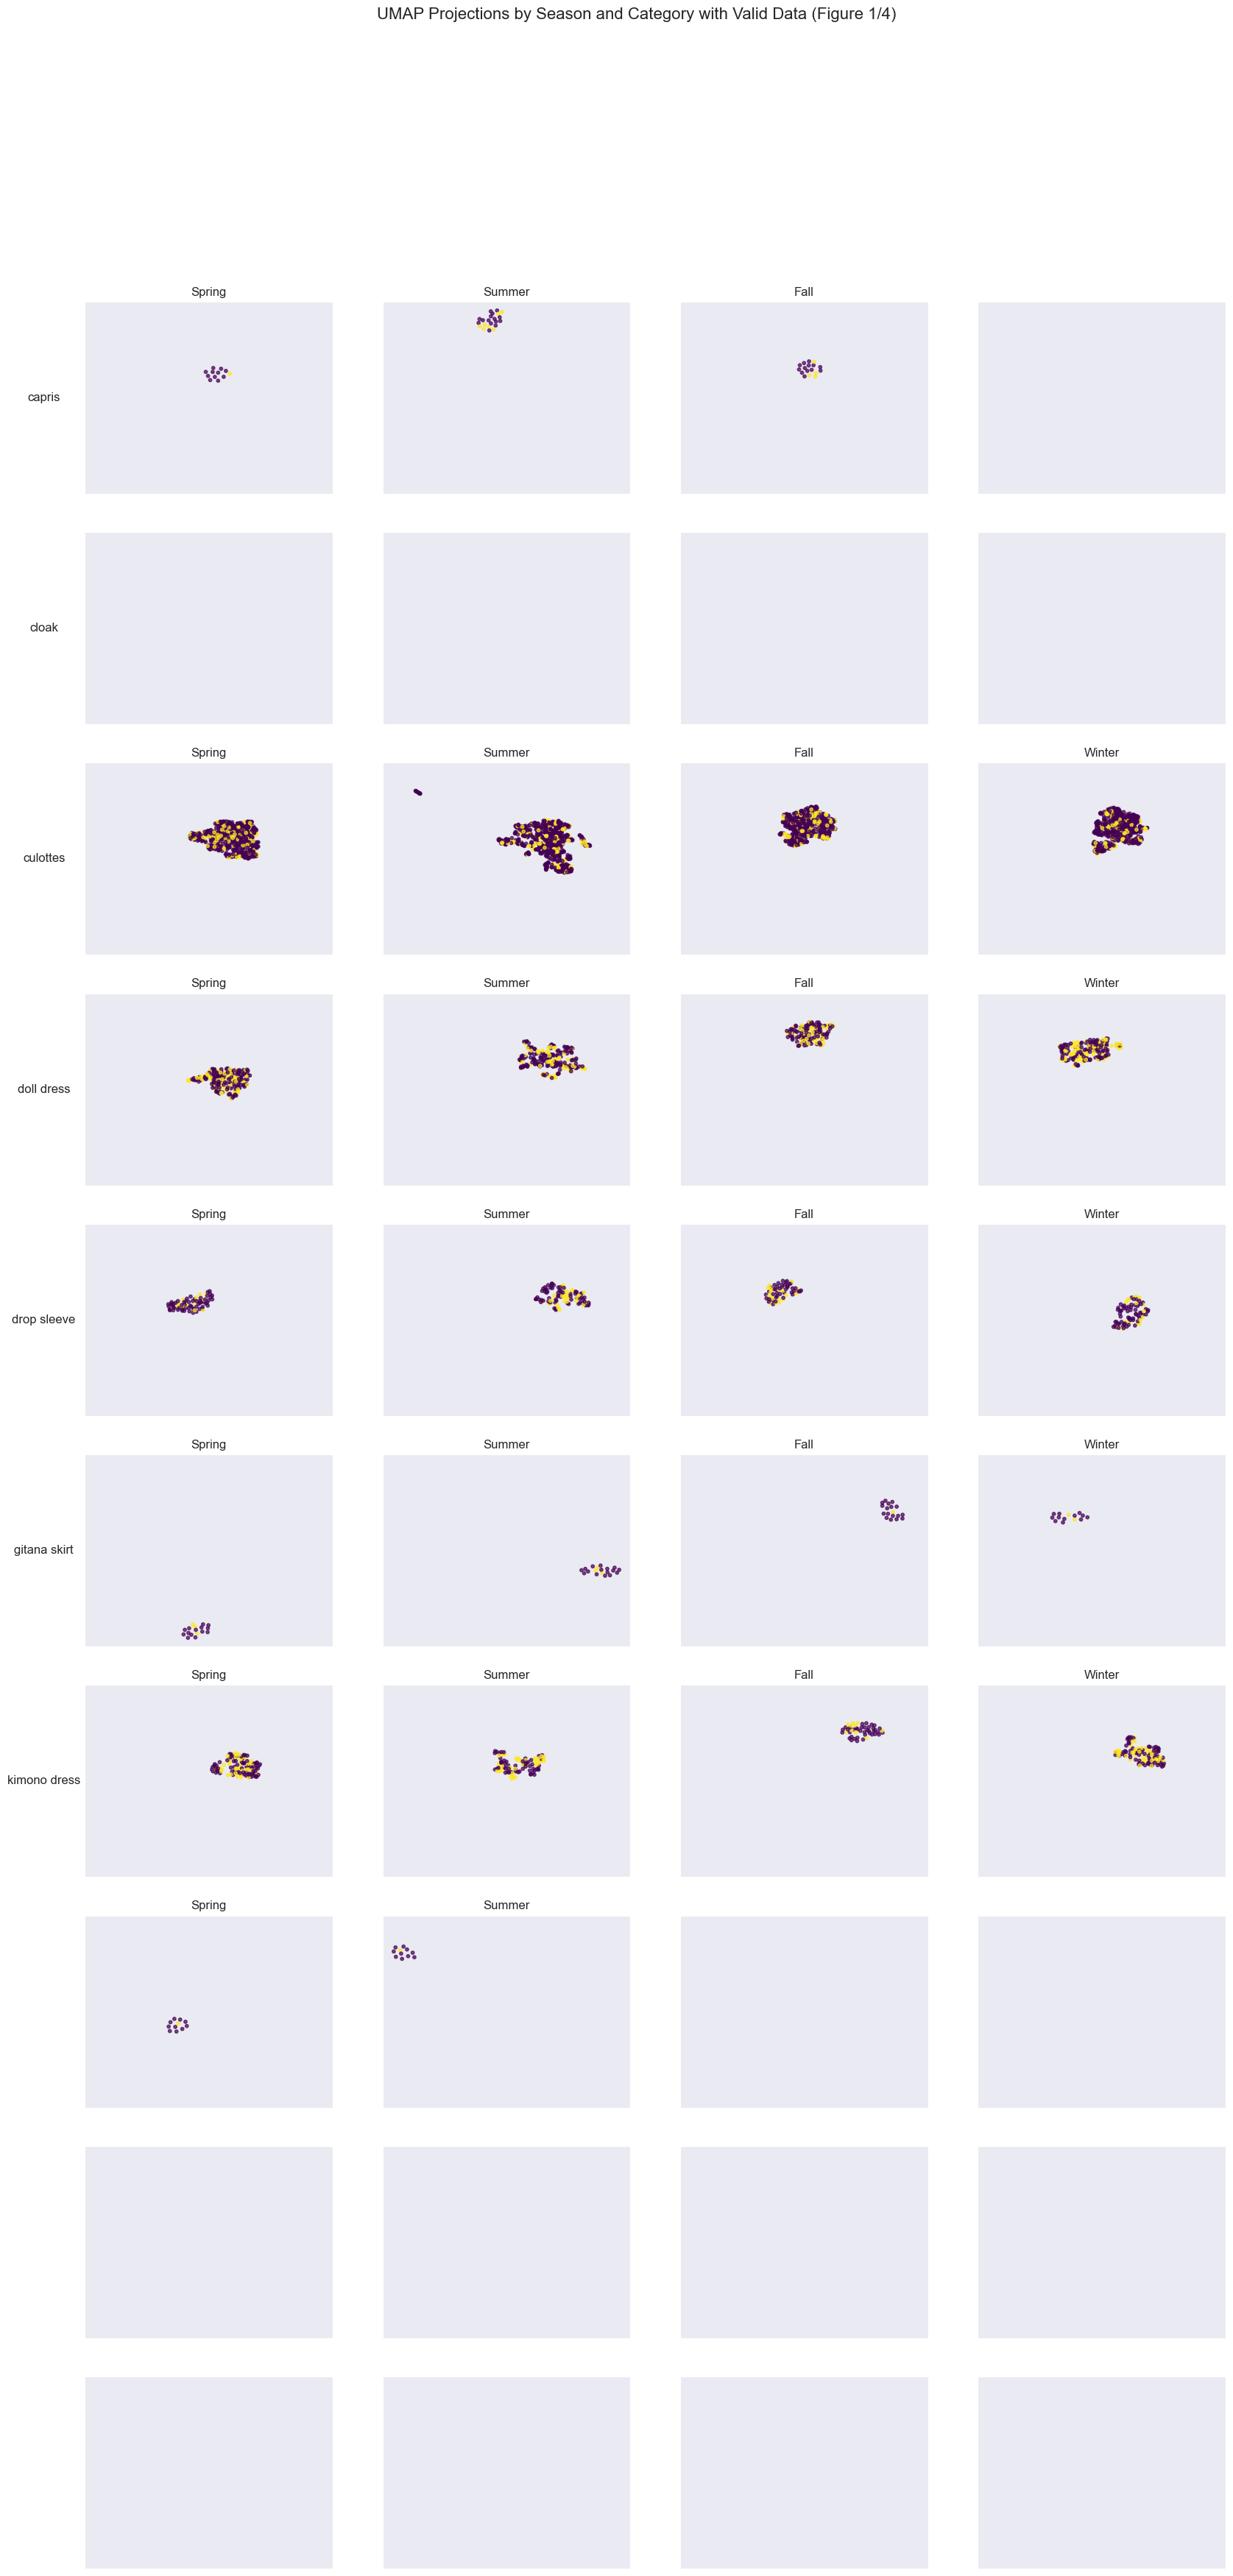

In [52]:
import matplotlib.pyplot as plt
import numpy as np
import umap

# Define seasons
seasons = ["Spring", "Summer", "Fall", "Winter"]

# Define the number of categories
num_categories = len(cat_dict)

# Define how many categories to display per figure to manage subplot sizes
categories_per_figure = 10  # Adjust this number based on your preference and available screen space

# Calculate the number of figures needed
num_figures = int(np.ceil(num_categories / categories_per_figure))

for fig_num in range(num_figures):
    # Determine the range of categories for the current figure
    start_idx = fig_num * categories_per_figure
    end_idx = min(start_idx + categories_per_figure, num_categories)
    current_categories = range(start_idx, end_idx)
    current_num_categories = end_idx - start_idx

    # Create subplots for the current figure
    fig, axes = plt.subplots(current_num_categories, 4, figsize=(20, 4 * current_num_categories), sharex=True, sharey=True)
    fig.suptitle(f'UMAP Projections by Season and Category with Valid Data (Figure {fig_num + 1}/{num_figures})', fontsize=16)
    
    # If there's only one category in the current figure, axes will not be a 2D array
    if current_num_categories == 1:
        axes = axes.reshape(1, -1)
    
    for ax_row, category_idx in zip(axes, current_categories):
        category_name = reversed_cat_dict[category_idx]
        
        for i, season in enumerate(seasons):
            # Fetch the data for the current season and category
            data = get_season_data(
                season_code=i,
                temporal_features_train=temporal_features_train,
                temporal_features_test=temporal_features_test,
                categories_train=categories_train,
                categories_test=categories_test,
                colors_train=colors_train,
                colors_test=colors_test,
                fabrics_train=fabrics_train,
                fabrics_test=fabrics_test,
                temporal_features_train_full=temporal_features_train,
                temporal_features_test_full=temporal_features_test,
                gtrends_train=gtrends_train,
                gtrends_test=gtrends_test,
                images_train=images_train,
                images_test=images_test,
                embeddings_train=embeddings_train,
                embeddings_test=embeddings_test,
                visual_words_train=visual_words_train,
                visual_words_test=visual_words_test,
                item_sales_train=item_sales_train,
                item_sales_test=item_sales_test
            )

            train_data = data['train']
            local_categories_train = train_data['categories']
            local_item_sales_train = train_data['item_sales']
            local_visual_words_train = train_data['visual_words']
            local_temporal_features_train = train_data['temporal_features']
            local_gtrends_train = train_data['gtrends']

            # Filter by specific category
            specific_category_indices = np.where(local_categories_train == category_idx)[0]
            if len(specific_category_indices) == 0:
                continue  # Skip empty categories

            # Calculate threshold and labels
            item_sales_combined = local_item_sales_train
            threshold = np.percentile(item_sales_combined[:, 0:4].sum(axis=1), 80)
            y_category = (local_item_sales_train[:, 0:4].sum(axis=1) >= threshold).astype(int)[specific_category_indices]

            X_category = np.column_stack([
                local_visual_words_train[specific_category_indices],
                local_temporal_features_train[specific_category_indices],
                local_gtrends_train[specific_category_indices, 0],
            ])

            if len(X_category) == 0:
                continue  # Skip if no valid data

            # Apply UMAP only if X_category is not empty
            if X_category.shape[0] > 0:
                umap_model = umap.UMAP(
                    n_neighbors=15,
                    min_dist=0.5,
                    metric='euclidean',
                    random_state=42
                )
                embedding = umap_model.fit_transform(X_category)

                # Plot on the corresponding subplot
                ax = ax_row[i]
                scatter = ax.scatter(
                    embedding[:, 0],
                    embedding[:, 1],
                    c=y_category,
                    cmap='viridis',
                    s=10,
                    alpha=0.7
                )
                ax.set_title(f"{season}")
                ax.set_xticks([])
                ax.set_yticks([])

        # Set a common ylabel for each category
        ax_row[0].set_ylabel(f"{category_name}", rotation=0, labelpad=40, fontsize=12, va='center')

    # Add a single colorbar for the entire figure
    fig.subplots_adjust(right=0.9, wspace=0.1, hspace=0.4)
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    if scatter:
        cbar = fig.colorbar(scatter, cax=cbar_ax)
        cbar.set_label('Sales Category (0: Below Threshold, 1: Above Threshold)')

    plt.tight_layout(rect=[0, 0, 0.9, 0.95])
    plt.show()

In [ ]:
def compute_percentile_thresholds(percentile=85):
    """
    Computes the threshold based on a given percentile for each category.

    Parameters:
    - percentile: The percentile to compute (default: 85).

    Returns:
    - A dictionary mapping categories to their thresholds.
    """
    thresholds = {}
    for category in np.unique(categories_train):
        # Select sales data for the current category
        category_sales = item_sales_train[categories_train == category, 0]
        # Compute the percentile threshold
        threshold = np.percentile(category_sales, percentile)

        # Store the threshold
        thresholds[category] = threshold
    return thresholds

# Example: Compute 85th percentile thresholds for all categories
percentile_thresholds = compute_percentile_thresholds(percentile=85)
print(percentile_thresholds)
